# Time Series Analysis

*A time series is a series of data points indexed (or listed or graphed) in time order* (Wikipedia). 

The goal of quantitative researchers is to identify trends, seasonal variations and correlation in financial data using statistical time series methods, and ultimately generate trading signals. In order to improve the profitability of our trading models, we must make use of statistical techniques to identify consistent behaviour in assets which can be exploited to turn a profit. To find this behaviour we must explore how the properties of the asset prices themselves change in time.

Time Series Analysis helps us to achieve this. **It provides us with a robust statistical framework for assessing the behaviour of time series, such as asset prices, in order to help us trade off of this behaviour.**


This is the first of a series of posts which will cover basic concepts related to statistical modeling of time series and various time series forecasting techniques.

This work derives from the works of Michael Halls-Moore on [Quantstart](https://www.quantstart.com/), [Quantopian Lecture Series](https://www.quantopian.com/lectures) and code borrowed from [seanabu.com](http://www.seanabu.com)


## Time Series Analysis - Part 1: Stationarity, Autocorrelation and White Noise

In this post, we will talk about two important concepts in time series analysis - Staionarity and Correlation. We recommend going through the math workbooks on [Expected Value and Variance](https://github.com/Auquan/Tutorials/blob/master/Expected%20Value%20and%20Standard%20Deviation.ipynb)
, [Correlation and Confidence Intervals](https://github.com/Auquan/Tutorials/blob/master/Covariance%2C%20Correlation%20and%20Confidence%20Intervals.ipynb) before this workbook.

In [1]:
import os
import sys

import pandas as pd
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [25]:
# from backtester.dataSource.yahoo_data_source import YahooStockDataSource

startDateStr = "2014/12/31"
endDateStr = "2017/12/31"
cachedFolderName = "\\Users\\dell\\Auquan\\auquantoolbox\\yahooData\\"
dataSetId = "testPairsTrading"
instrumentIds = ["^GSPC", "DOW", "MSFT"]
# ds = YahooStockDataSource(
#     cachedFolderName=cachedFolderName,
#     dataSetId=dataSetId,
#     instrumentIds=instrumentIds,
#     startDateStr=startDateStr,
#     endDateStr=endDateStr,
#     event="history",
# )
# data = ds.getBookDataByFeature()["adjClose"]
# log returns
import yfinance as yf


def get_data(symbol):
    data = yf.download(symbol, start="2012-01-01", end="2017-01-01")
    data = data["Adj Close"]
    return data


data = get_data(instrumentIds[0])
lrets = np.log(data / data.shift(1)).dropna()

[*********************100%***********************]  1 of 1 completed


## Stationarity

Stationarity is an extremely important aspect of time series -  much of the analysis carried out on financial time series data involves identifying if the series we want to predict is stationary, and if it is not,finding ways to transform it such that it is stationary. 

*Mean of a time series $x_t$ is $E(x_t)=\mu(t)$*

*Variance of a time series $x_t$ is $\sigma^2(t)=E[(x_t - \mu(t))^2]$*

**A time series is stationary in the mean if $\mu(t)=\mu$, i.e.mean is constant with time**

**A time series is stationary in the variance if $\sigma^2(t)=\sigma^2$, i.e. variance is constant with time**

This image from SEANABU.COM should help 

![Courtsey: SEANABU.COM ](download.png)

For more details, see the notebook on [Stationarity](https://github.com/Auquan/Tutorials/blob/master/Integration%2C%20Cointegration%2C%20and%20Stationarity.ipynb)

### Why do we care about stationarity? 

A stationary time series (TS) is simple to predict as we can assume that future statistical properties are the same or proportional to current statistical properties.

Most of the models we use in TSA assume covariance-stationarity (#3 above). This means the predictions of these models - means, variances, and correlations, are only reliable if the TS is stationary and invalid otherwise.

## Serial Correlation (Autocorrelation)

A time series model decomposes the series into three components: trend, seasonal/cyclical, and random. 

The random component is called the residual or error - the difference between our predicted value(s) and the observed value(s). Autocorrelation is when these residuals (errors) are correlated with each other. That is, if the error of the $i_{th}$ is dependent on errors of any of the terms $0 .. i-1$ before. Essentially, it tells us how sequential observations in a time series affect each other. 

Formally, for a covariance-stationary time series (as #3 above, where covariance between sequential observations is not a function of time), autocorrelation $\rho_k$ for lag $k$ (the number of time steps separating two sequantial observations), $$
\rho_k = \frac{COV(x_t, x_{t - k})}{\sigma_x^2} = \frac{E[(x_t - \mu)(x_{t - k} - \mu)}{\sigma_x^2}
$$

A significant value of $\rho_k$ indicates that the error of the $i_{th}$ is dependent on the previous k terms from ${i-k} .. {i-1}$.

### Why Do We Care about Serial Correlation? 

Serial correlation is critical for the validity of our model predictions - The residuals (errors) of a stationary TS are serially uncorrelated by definition. It is critical we account for autocorrelation in our model otherwise the standard errors of our estimates for the parameters will be biased and underestimated, making any tests that we try to form using the model invalid In layman's terms, ignoring autocorrelation means we're likely to draw incorrect conclusions about the impact of the independent variables in our model.

## White Noise

By definition *a time series that is a white noise process has serially uncorrelated errors and the expected mean of those errors is equal to zero.* This means that the errors(residuals) are completely drawn at random from some probability distribution, i.e it is independent and identically distributed (i.i.d.). 

If our time series model results in white noise residuals, it means we have successfully captured the underlying process and explained any form of correlation, only leaving errors(residuals) which are completely random. Our predicted values differ from the observed values only by a random error component that cannot be forecasted or modeled.

Most of time series analysis is literally trying to fit a model to the time series such that the residual series is indistinguishable from white noise.

Let's simulate a white noise process and view it.

In [8]:
def tsplot(y, lags=None, figsize=(15, 10), style="bmh"):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        # mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title("Time Series Analysis Plots")
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line="s", ax=qq_ax)
        qq_ax.set_title("QQ Plot")
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

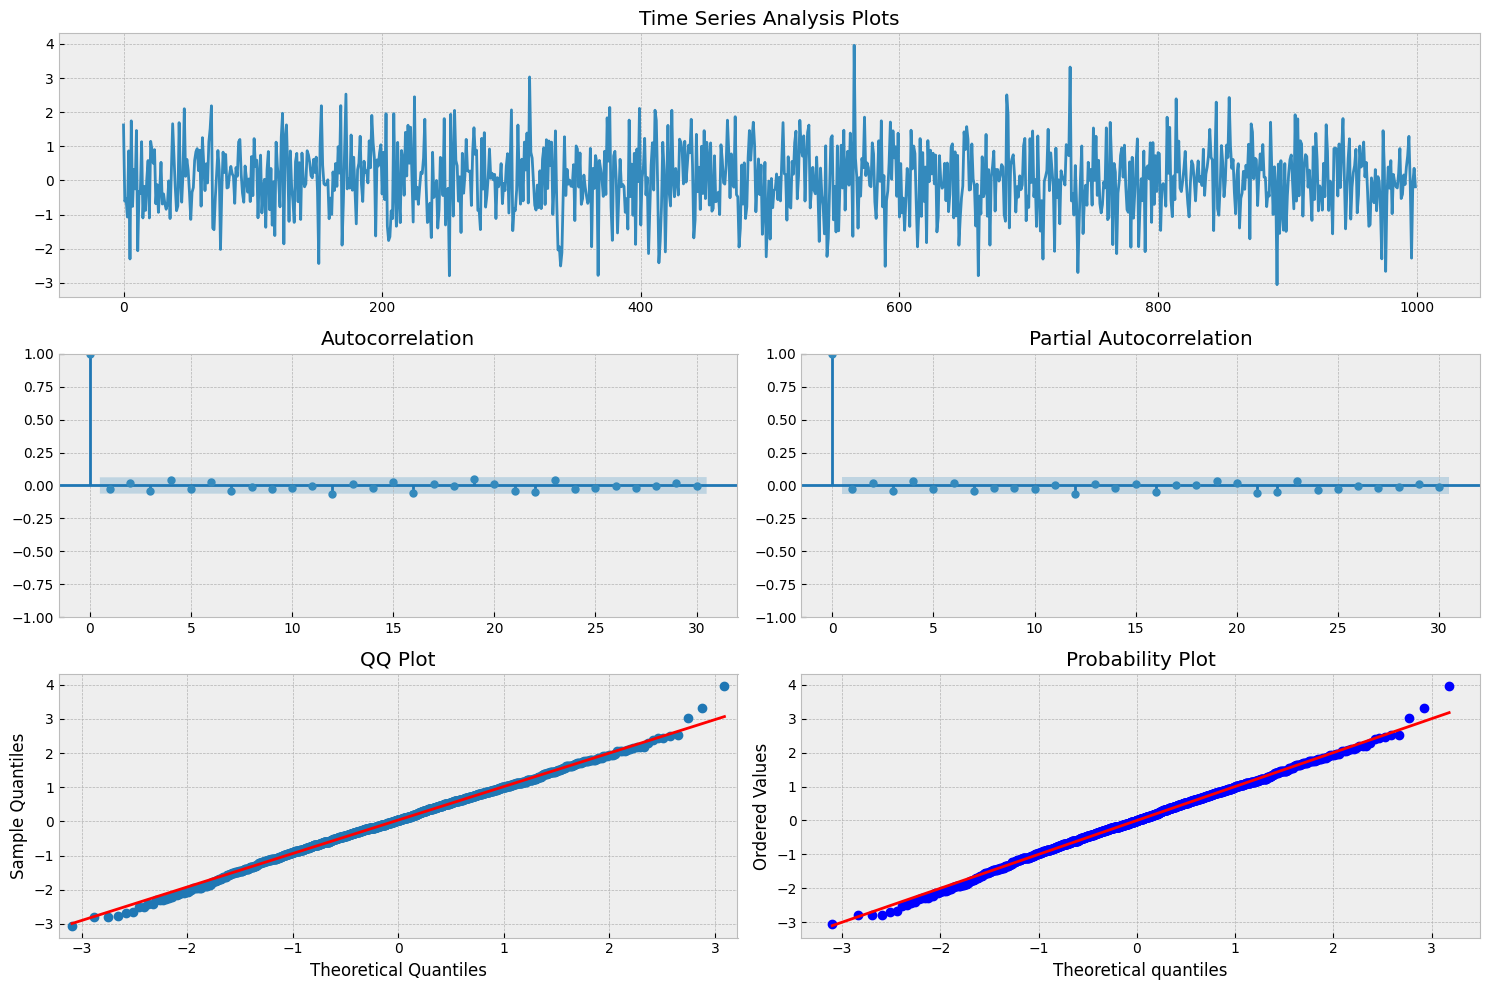

In [12]:
np.random.seed(1)

# plot of discrete white noise
randser = np.random.normal(size=1000)
tsplot(randser, lags=None)

### A word on the plots here:

* The top plot is the values of time series itself 
* The second row has plots of autocorrelation (ACF) and partial autocorrelation (PACF). The PACF is partial correlation between residuals, controlling for shorter lags.
 * The x axis shows the values of the lag, $k$ and the blue shaded region show significance boundaries. Only values that lie outside the blue region are significant
* The third row has QQ plots and probability plots
 * QQ plot compares two probability distributions by plotting their quantiles against each other - If the two distributions are similar (orlinearly related), the points in the Q–Q plot will approximately lie on a line. For this discussion, we are comparing the distribution of our residuals with a normal distribution
 * Similarly, normal probability plot also asseses whether or not a data set is approximately normally distributed. The data are plotted against a theoretical normal distribution in such a way that the points should form an approximate straight line. Departures from this straight line indicate departures from normality.

We note the following:

* The process appears to be random and centered about zero
* The autocorrelation (ACF) and partial autocorrelation (PACF) plots also indicate no significant serial correlation (Remember we should see approximately 5% significance in the autocorrelation plots due to pure chance as a result of sampling from the Normal distribution)
* Below that we can see the QQ and Probability Plots, which compares the distribution of our data with standard normal distribution are straight lines

In [13]:
print(
    "Random Series\n -------------\nmean: %.3f \nvariance: %.3f \nstandard deviation: %.3f"
    % (randser.mean(), randser.var(), randser.std())
)

Random Series
 -------------
mean: 0.039 
variance: 0.962 
standard deviation: 0.981


Clearly our data is distributed randomly, and appears to follow Gaussian (Normal) white noise, as it should. 

## Random Walk

A random walk is a time series model where the value of the time series variable increases or decreases (step up or down) with equal probability at each time step, that is the expected value of current observation is equal to the previous observation. It is formally defined below:

$$x_t=x_{t-1}+w_t$$ , where $w_t$ is a discrete white noise series.
$$E[x_t]=x_{t-1}$$

This means if the TS we are modeling is a random walk it is unpredictable, as they are literally random walks.

The significance of a random walk is that it is non-stationary because while the mean of a random walk is still zero, the covariance is actually time-dependent. In particular, the covariance is equal to the variance multiplied by the time. Hence, as time increases, so does the variance.

Let's simulate a random walk 

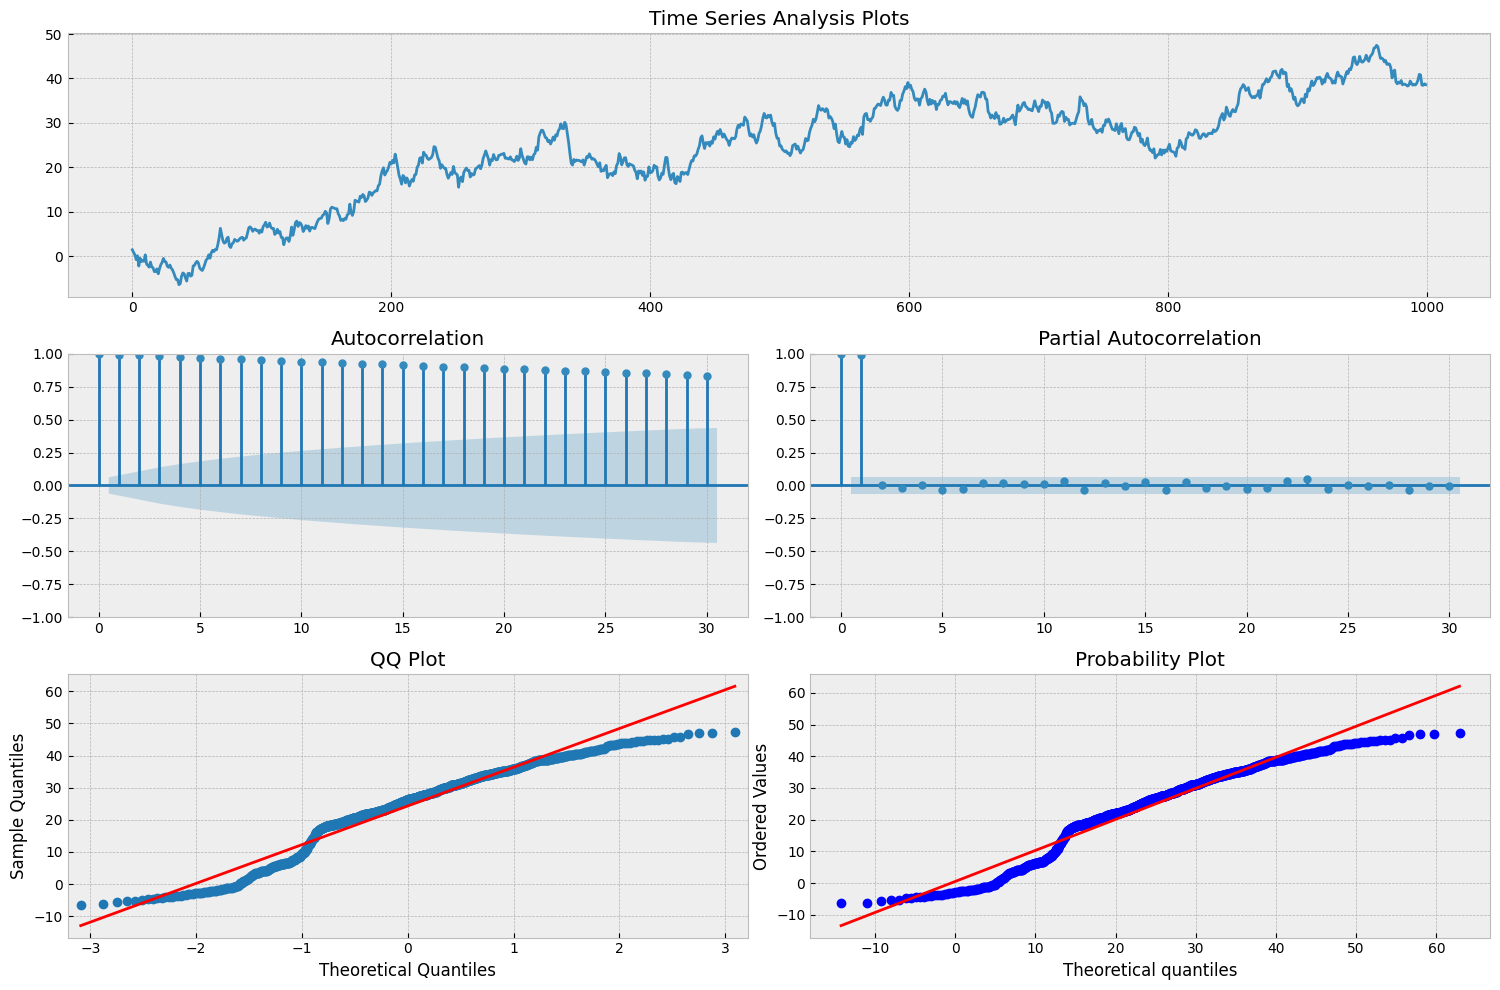

In [14]:
# Random Walk without a drift

np.random.seed(1)
n_samples = 1000

x = w = np.random.normal(size=n_samples)
for t in range(n_samples):
    x[t] = x[t - 1] + w[t]

_ = tsplot(x, lags=30)

Clearly our TS is not stationary. How to check if the random walk model is a good fit for our simulated data? We have

$$x_t - x_{t-1} = w_t$$ , where $w_t$ is a discrete white noise series.

The first differences of our random walk series should equal a white noise process!

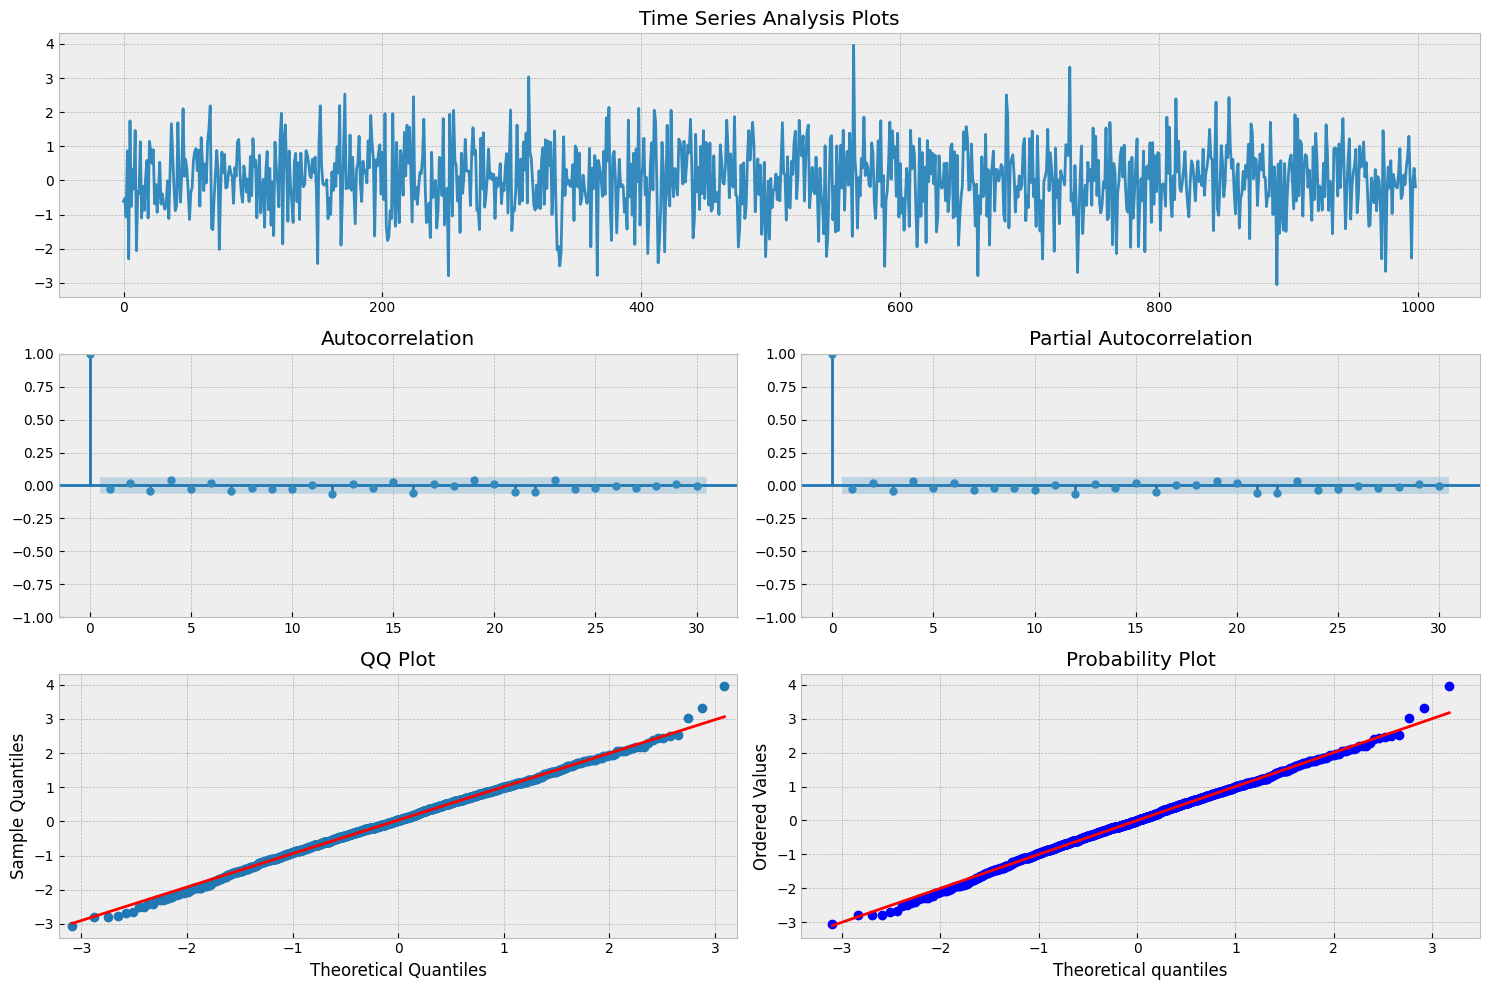

In [15]:
# First difference of simulated Random Walk series
_ = tsplot(np.diff(x), lags=30)

As expected, the difference is indeed white noise.

Let's now apply our random walk model to some actual financial data. 

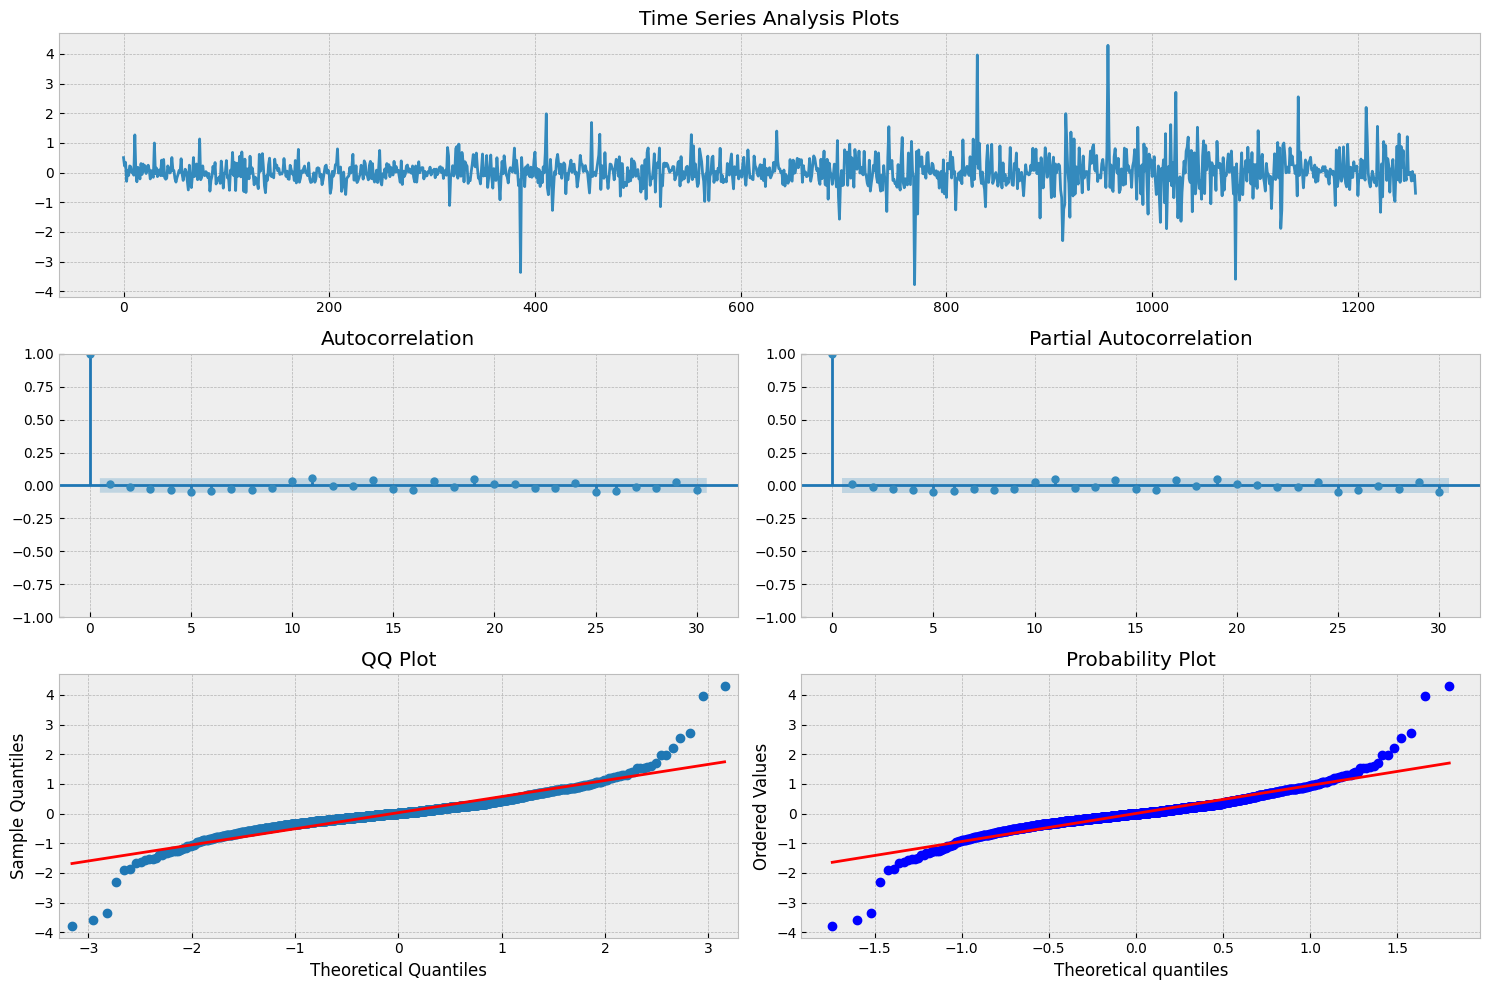

In [24]:
# First difference of SPX prices
_ = tsplot(np.diff(data), lags=30)

It's quite similar to white noise, isn't it? However, there appears to be some significant serial correlation in the ACF, and PACF plots around lags 1, 10, 15, 18 and 21. Also notice the shape of the QQ and Probability plots. This indicates that the process is close to normality but with 'heavy tails'. This means that there should be better models to explain the price of S&P 500.

Let's try the same on other equities'

[*********************100%***********************]  1 of 1 completed


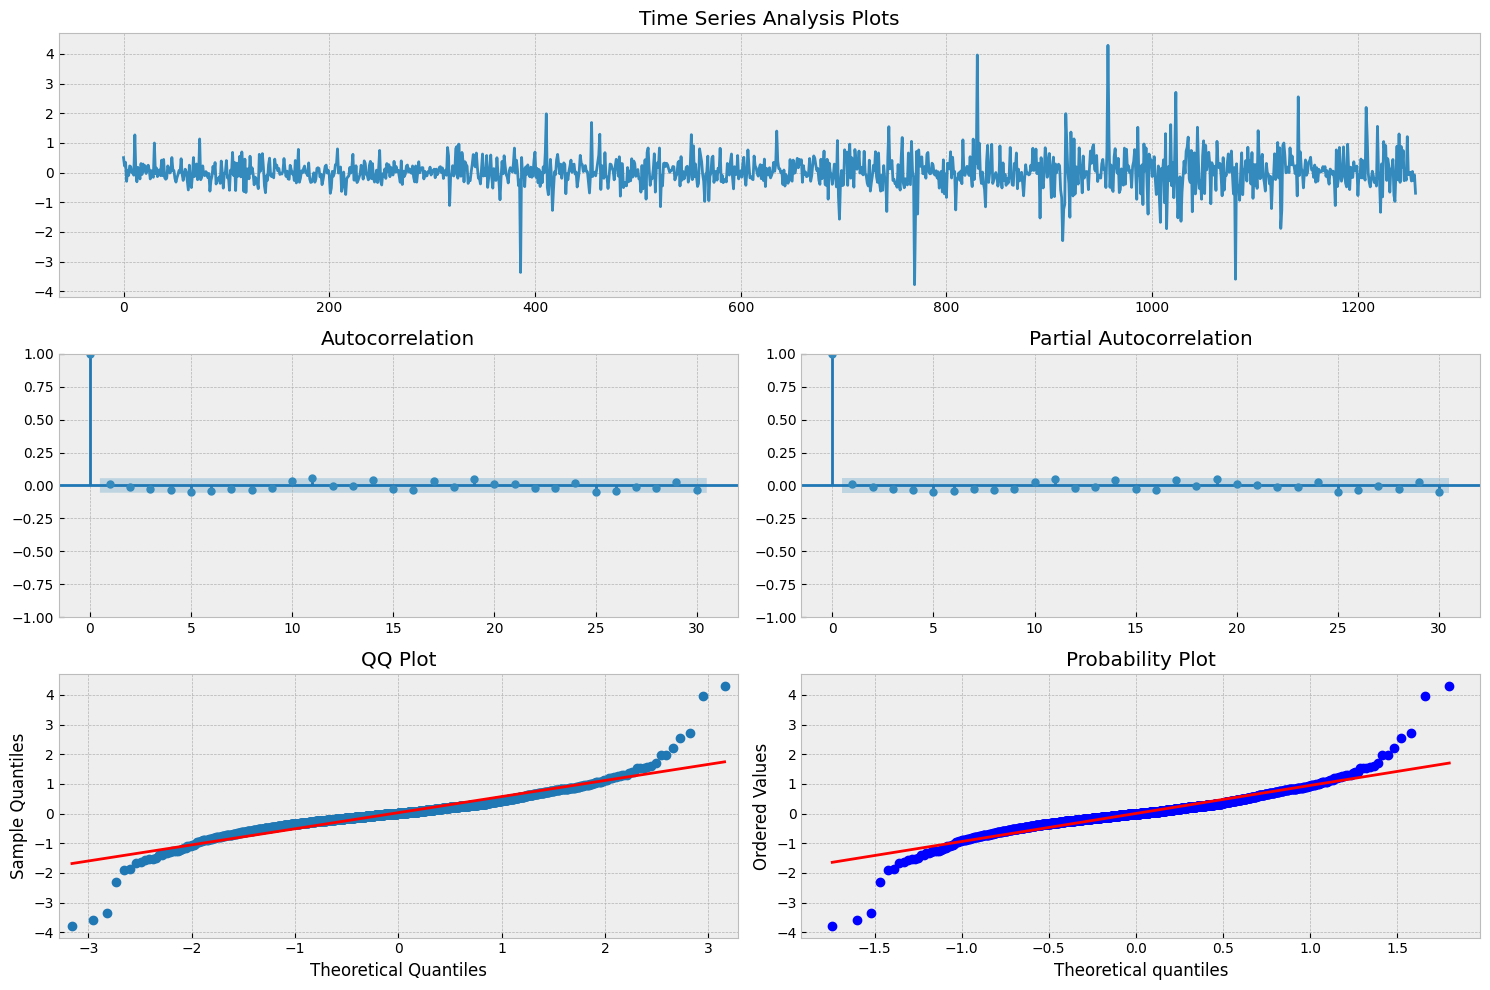

In [26]:
# First difference of MSFT prices
data = get_data("MSFT")
_ = tsplot(np.diff(data), lags=30)

Again the time series is quite similar to white noise with similar 'heavy tails' a few peaks in the ACF, and PACF plots.

Before we conclude, let's talk about two more simple TS models.

## Linear Models

Linear models aka trend models represent a TS that can be graphed using a straight line. The basic equation is:
$$x_{t} = a_0+a_1 t + b$$

The value of the time series is determined by the coefficients, $a_0, a_1$ and *time*. An example could be a company's sales that increase by the same amount at each time step. For a hypthtical example, consider a company who's stock price was a 100$ to start, and increase by 50c at every time step. 

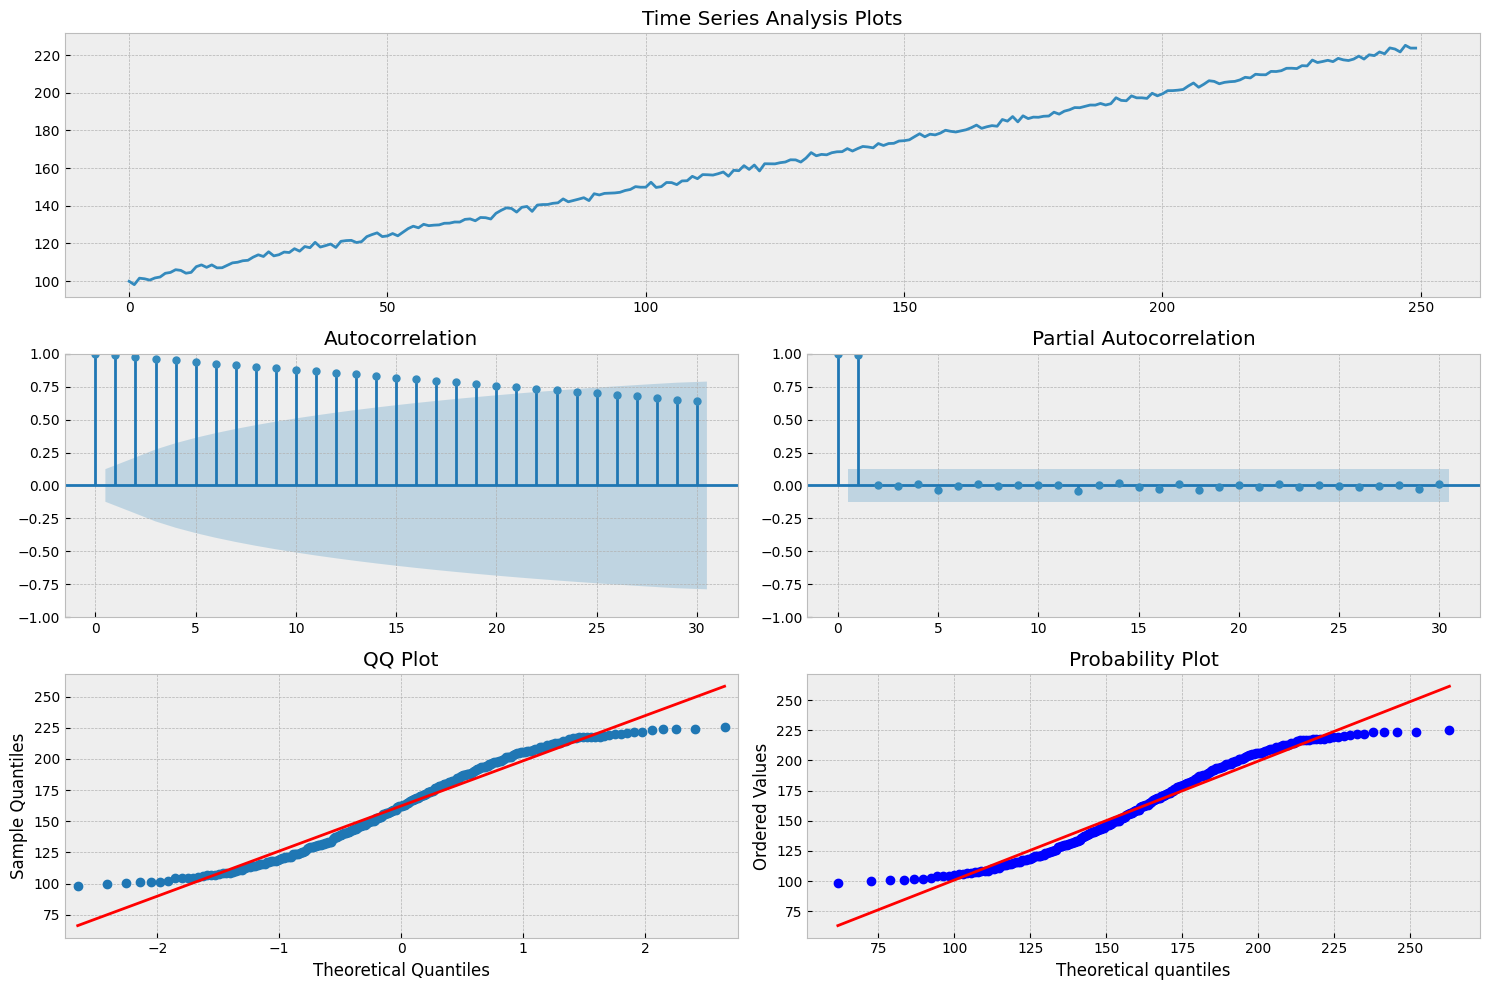

In [27]:
# simulate linear trend

w = np.random.randn(250)
x = np.empty_like(w)

a0 = 100.0
a1 = 0.5
for t in range(len(w)):
    x[t] = a0 + a1 * t + w[t]

_ = tsplot(x, lags=30)

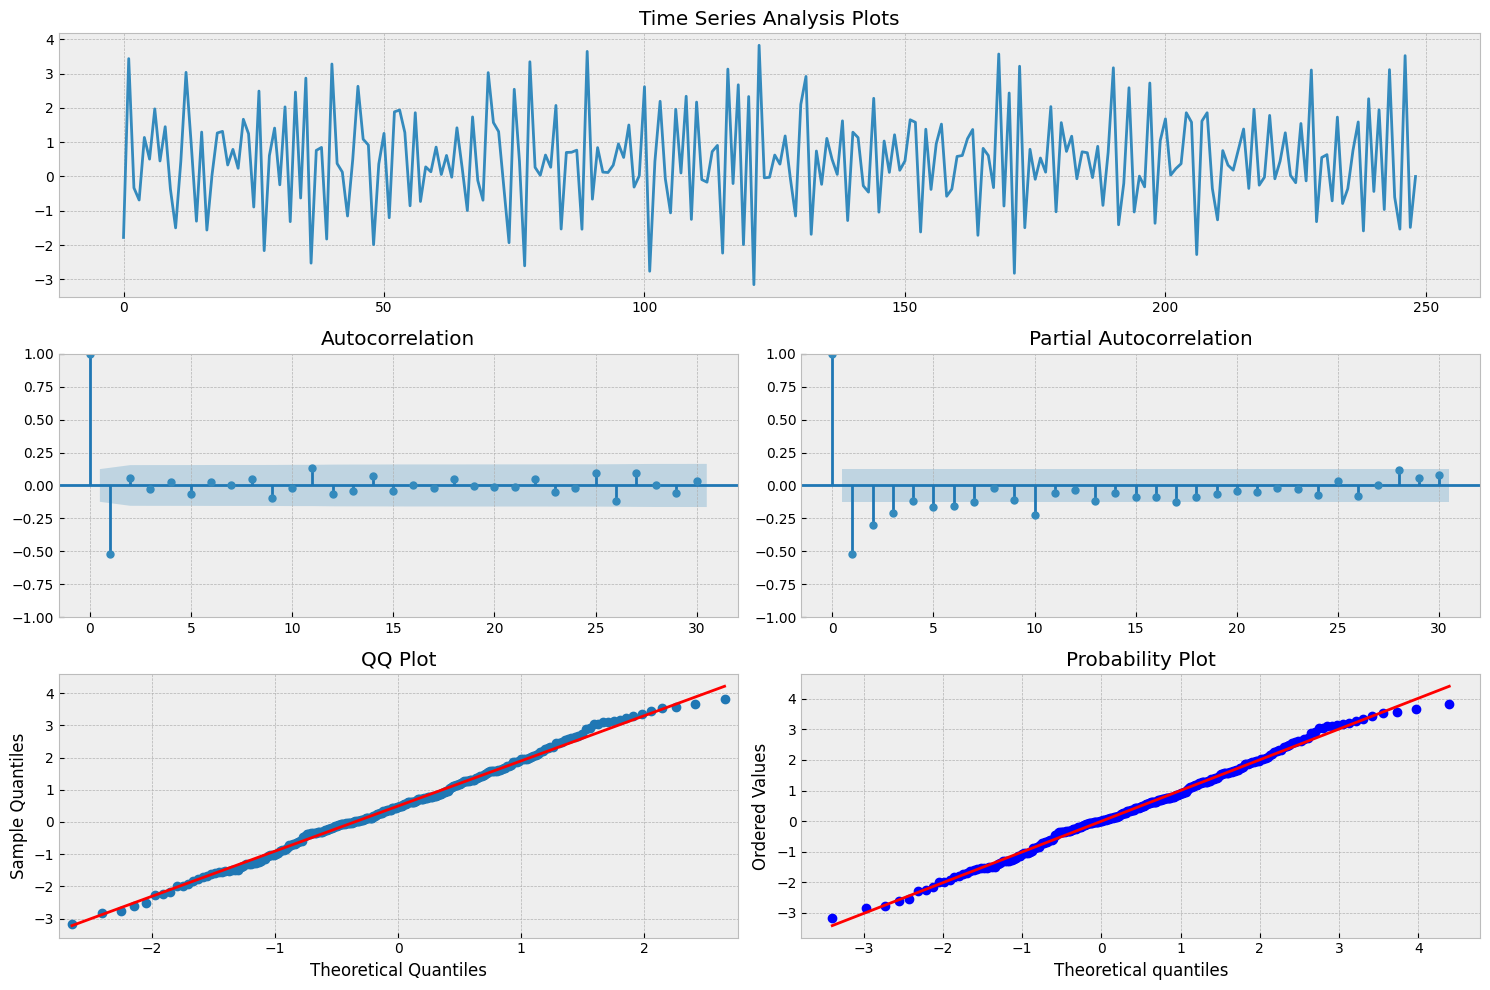

In [28]:
# First difference of simulated prices
_ = tsplot(np.diff(x), lags=30)

Here we can see that the residuals of the model are correlated. Though the distribution is approximately normal, before using this model to make predictions we would have to account for and remove the obvious autocorrelation (the significant value at lag 1) present in the series. The significance of the PACF at lag 1 indicates that an autoregressive model may be appropriate( we will discuss this in next sheet)

## Log-Linear Models

Similar to linear models except that the TS that can be graphed using an exponential function. That is the the time series has a constant rate of change with respect to each time step. 
$$x_{t} = exp(a_0+a_1 t)$$
$$log(x_{t}) = a_0+a_1 t$$
$$x_0 = exp(a_0)$$
$$x_t = x_{t-1}*exp(a1)$$
For example, in our above simulated series, if the stock price increased by X% at each time step, you get a curve that looks like this:

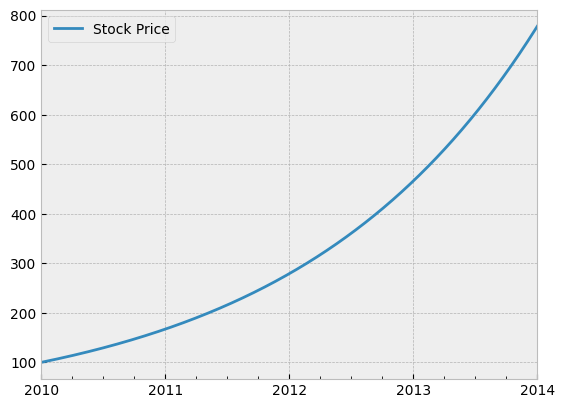

In [29]:
# Simulate exponential growth

idx = pd.date_range("2010-01-01", "2014-01-01", freq="D")
price = [np.exp(4.605 + float(x) / 712) for x in range(0, len(idx))]

# create dataframe and plot
df = pd.DataFrame(price, columns=["Stock Price"], index=idx)

with plt.style.context("bmh"):
    df.plot()

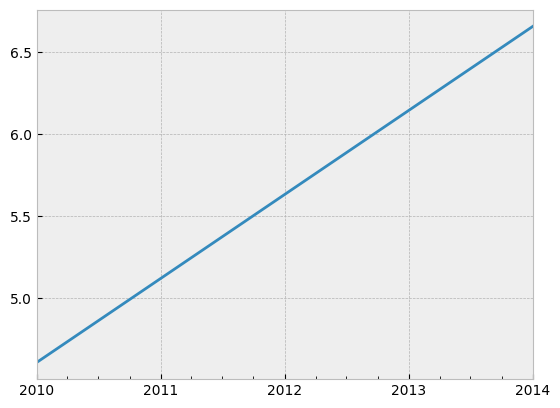

In [30]:
# log of prices

with plt.style.context("bmh"):
    pd.Series(np.log(price), index=idx).plot()

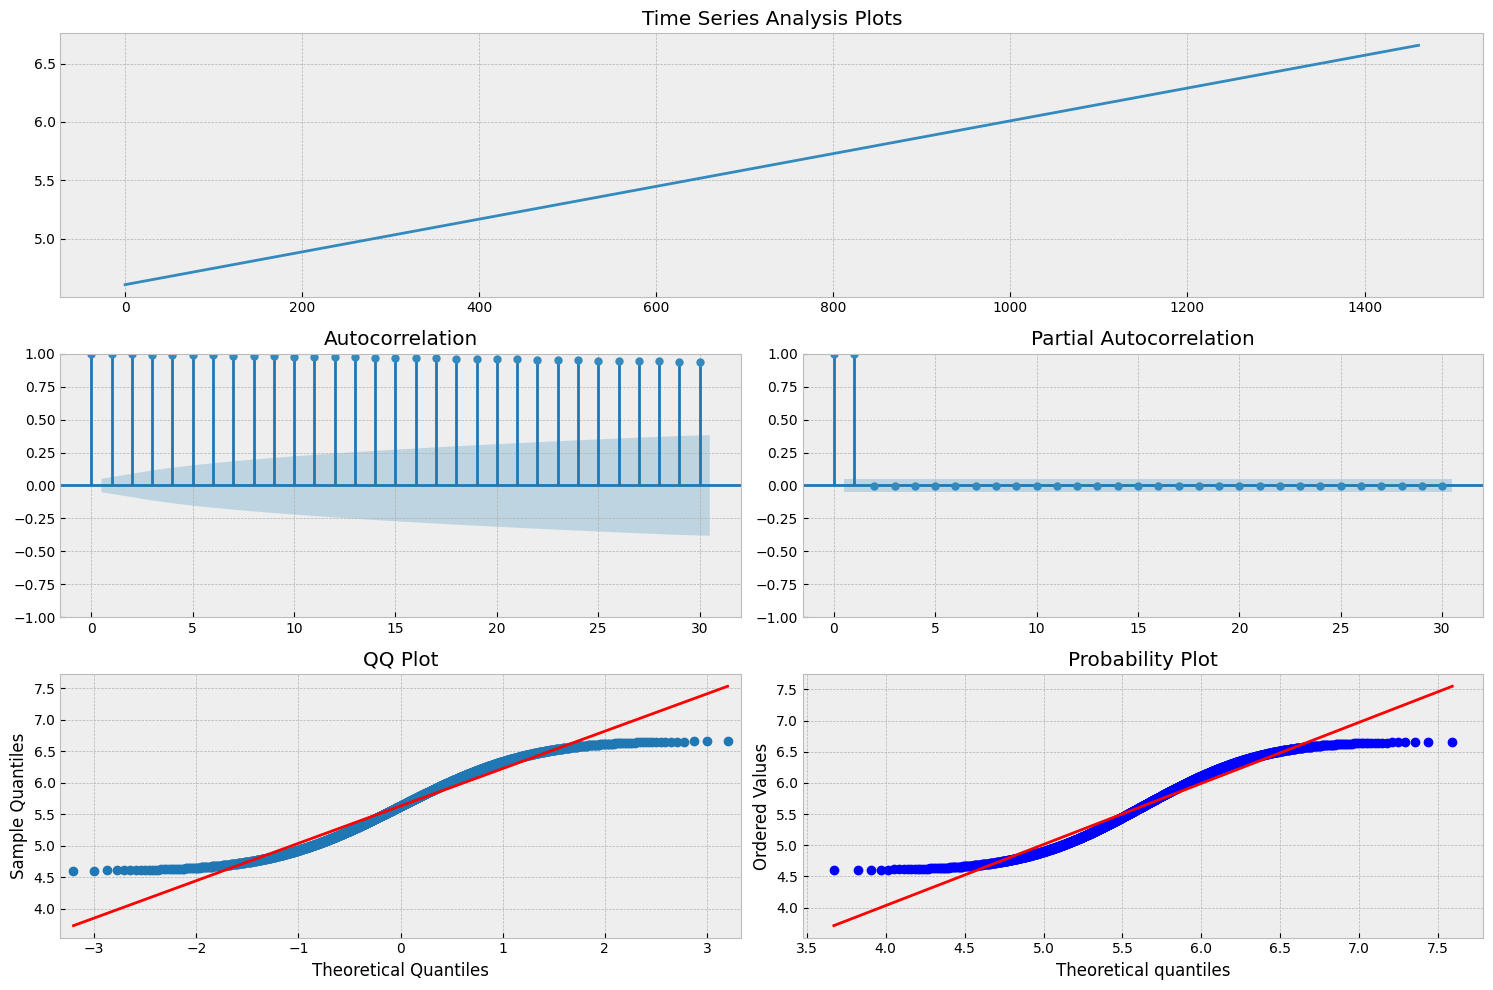

In [31]:
_ = tsplot(np.log(price), lags=30)

This notebook provides a basic overview of time series analysis. The tests for stationarity, random walk are a common process we will keep visiting in further notebooks. We're next going to talk about more sophisticated time series models.